This is just a notebook to try new things out, like Parameter Vector and the proper Estimator Primitive that I figured out how to use properly.

In [4]:
from qiskit_ibm_runtime import EstimatorV2
import numpy as np
from qiskit import QuantumCircuit, transpile, QuantumRegister
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp
from qiskit.visualization import plot_histogram, plot_state_city
import qiskit.quantum_info as qi
import time
from qiskit.circuit import Parameter, ParameterVector
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime.fake_provider import FakeQuitoV2 


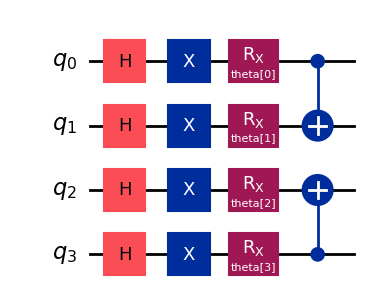

In [5]:
qubits = 4

q1 = QuantumRegister(qubits, "q")
qc = QuantumCircuit(q1)

parameters = ParameterVector("theta", 4)

Observables = [
    SparsePauliOp("ZZZZ"),
    SparsePauliOp("IIII"),
    SparsePauliOp("XZZX"),
]


qc.h(q1)
qc.x(q1)
for i in range(4):
    qc.rx(parameters[i],i)
qc.cx(q1[0],q1[1])
qc.cx(q1[3],q1[2])

qc.draw("mpl")

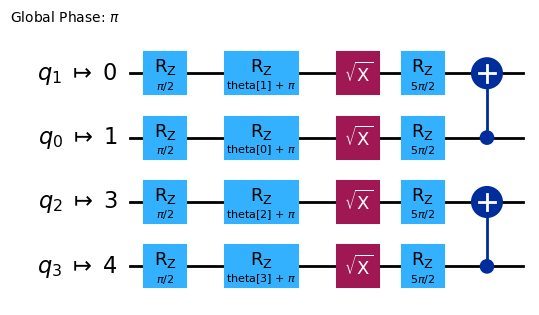

In [6]:
backend = FakeQuitoV2()

estimator = EstimatorV2(mode=backend)

qc_t = transpile(qc, backend=backend)

isa_Observables = []
for i in range(len(Observables)):
    isa_Observables.append(Observables[i].apply_layout(qc_t.layout)) # Makes new observables to match the qubits in computer

qc_t.draw("mpl")

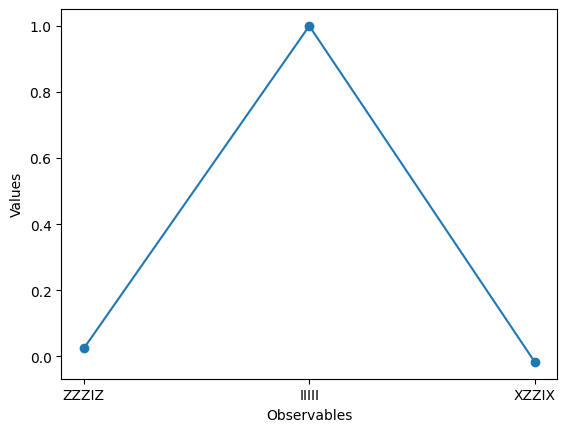

In [7]:
# Running this 

params =  np.linspace(-np.pi/2,np.pi/2,4)

pub = (qc_t,isa_Observables,params) # Makes a pub to run, its a tuple with (circuit, Observable, parameters)

job = estimator.run([pub]).result()

results = job[0]

thing = results.data.evs #First number is expectation value of Observables[0], second with Observables[1], and so on.

from matplotlib import pyplot as plt

plt.plot(["ZZZIZ","IIIII","XZZIX"], thing, "-o")
plt.xlabel("Observables")
plt.ylabel("Values")
plt.show()

So thats with using the formal Estimator Primitive in Qiskit. Instead of using the one Aer has. Now let me try to make several parametrizations to see effects.  

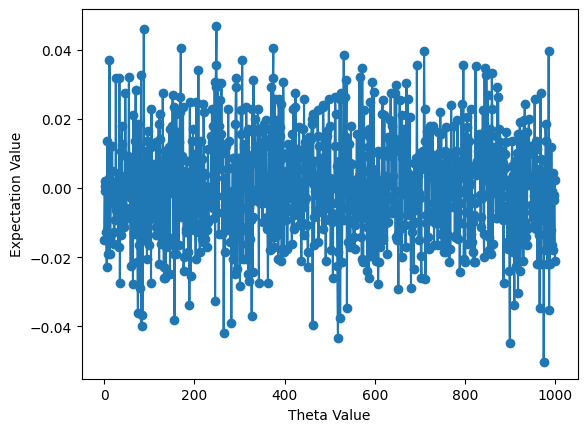

this took 59.951010942459106 seconds


In [8]:
start = time.time()

thetas = np.linspace(-np.pi/2,np.pi/2,1000)

Observable = SparsePauliOp("ZZZZ") #Reduce the number of observables so that its nice to graph can work
isa_observable = Observable.apply_layout(qc_t.layout)
jobs = []

for i in range(len(thetas)):
    pub = (qc_t, isa_observable, [thetas[i],thetas[i],thetas[i],thetas[i]])
    jobs.append(estimator.run([pub]).result()[0].data.evs)

plt.plot(range(len(thetas)), jobs, "-o")
plt.xlabel("Theta Value")
plt.ylabel("Expectation Value")
plt.show()

end = time.time()
print(f"this took {end-start} seconds")

## Notes

- You can make your own observables for the estimator primitive, but as they need to be mapped to the qubits in the device you must use `Observables.apply_layout(qc_t.layout)` to make the observable layout match the actual ciruit. All this does is automatically add I's where there need to be.
- Use `estimator.run([pub]).result()[0].data.evs` for the estimator from Qiskit, not the one from Aer. I'm still not too sure when I should use the Aer or Qiskit's primitives, so I'll ask that when I can. 